# 1. EXTRACT

In [52]:
# bibliotecas
import pandas as pd
from matplotlib import pyplot as plt
from inflection import underscore
from fpdf import FPDF

# dados
df_raw=pd.read_excel('./data/empresa_db.xlsx')

## Variáveis Importantes

In [53]:
azuis=['#0678B1','#078CCF','#13ABF6','#3AB9F8','#62C7F9','#89D5FB','#B0E3FC']
verdes=['#0CAC44','#0ED151','#1AEF65','#40F27E','#66F498','#66F498','#8DF7B2']

## Funções

In [71]:
def maiores(df_graf,n_graf):
    col1=df_graf.columns[0]
    col2=df_graf.columns[1]
    df_graf['teste']=df_graf.iloc[:,0].head(n_graf)
    df_graf['teste'].fillna(0,inplace=True)
    df_graf.iloc[df_graf['teste']==0,0]='OUTROS'
    df_graf.drop(columns='teste',inplace=True)
    df_graf=df_graf.groupby(col1).sum().reset_index().sort_values(col2,ascending=False)
    t=df_graf.loc[df_graf[col1]=='OUTROS',:]
    df_graf.drop(df_graf.loc[df_graf[col1]=='OUTROS'].index,inplace=True)
    df_graf=df_graf.append(t)
    df_graf
    return(df_graf)

# 2. TRANSFORM

## Dados

In [55]:
df1 = df_raw.copy()

In [56]:
# transformar em snake case
cols_old=['DATA_CONTRATO', 'NOME_BANCO', 'CPF', 'NOME_CLIENTE', 'VALOR_CREDI',
       'FILIAL', 'OPER', 'STATUS', 'NOME_PRODUTO']
cols_new=list(map(lambda x: underscore(x),cols_old))
df1.columns=cols_new

# correção de dados
df1['achar']=df1['nome_produto'].str.find('AERONAUTICA')
df1['nome_produto']=df1[['achar','nome_produto']].apply(lambda x: 'AERONAUTICA' if x['achar']!=-1 else x['nome_produto'],axis=1)
df1['achar']=df1['nome_produto'].str.find('DEBITO')
df1['nome_produto']=df1[['achar','nome_produto']].apply(lambda x: 'DEB EM CONTA' if x['achar']!=-1 else x['nome_produto'],axis=1)
df1['achar']=df1['nome_produto'].str.find('ESTADO')
df1['nome_produto']=df1[['achar','nome_produto']].apply(lambda x: 'ESTADO' if x['achar']!=-1 else x['nome_produto'],axis=1)
df1['achar']=df1['nome_produto'].str.find('FEDERAL')
df1['nome_produto']=df1[['achar','nome_produto']].apply(lambda x: 'FEDERAL' if x['achar']!=-1 else x['nome_produto'],axis=1)
df1['achar']=df1['nome_produto'].str.find('FGTS')
df1['nome_produto']=df1[['achar','nome_produto']].apply(lambda x: 'FGTS' if x['achar']!=-1 else x['nome_produto'],axis=1)
df1['achar']=df1['nome_produto'].str.find('INSS')
df1['nome_produto']=df1[['achar','nome_produto']].apply(lambda x: 'INSS' if x['achar']!=-1 else x['nome_produto'],axis=1)
df1['achar']=df1['nome_produto'].str.find('MARINHA')
df1['nome_produto']=df1[['achar','nome_produto']].apply(lambda x: 'MARINHA' if x['achar']!=-1 else x['nome_produto'],axis=1)
df1['achar']=df1['nome_produto'].str.find('PREF')
df1['nome_produto']=df1[['achar','nome_produto']].apply(lambda x: 'PREF RJ' if x['achar']!=-1 else x['nome_produto'],axis=1)
df1.drop(columns='achar',inplace=True)

# feature engeneering
df1['semana_ano']=df1['data_contrato'].dt.isocalendar().week

In [57]:
# criando variáveis
operadores=df1['oper'].unique().tolist()

## Graficos

In [58]:
df2=df1.copy()

### Grafico Geral

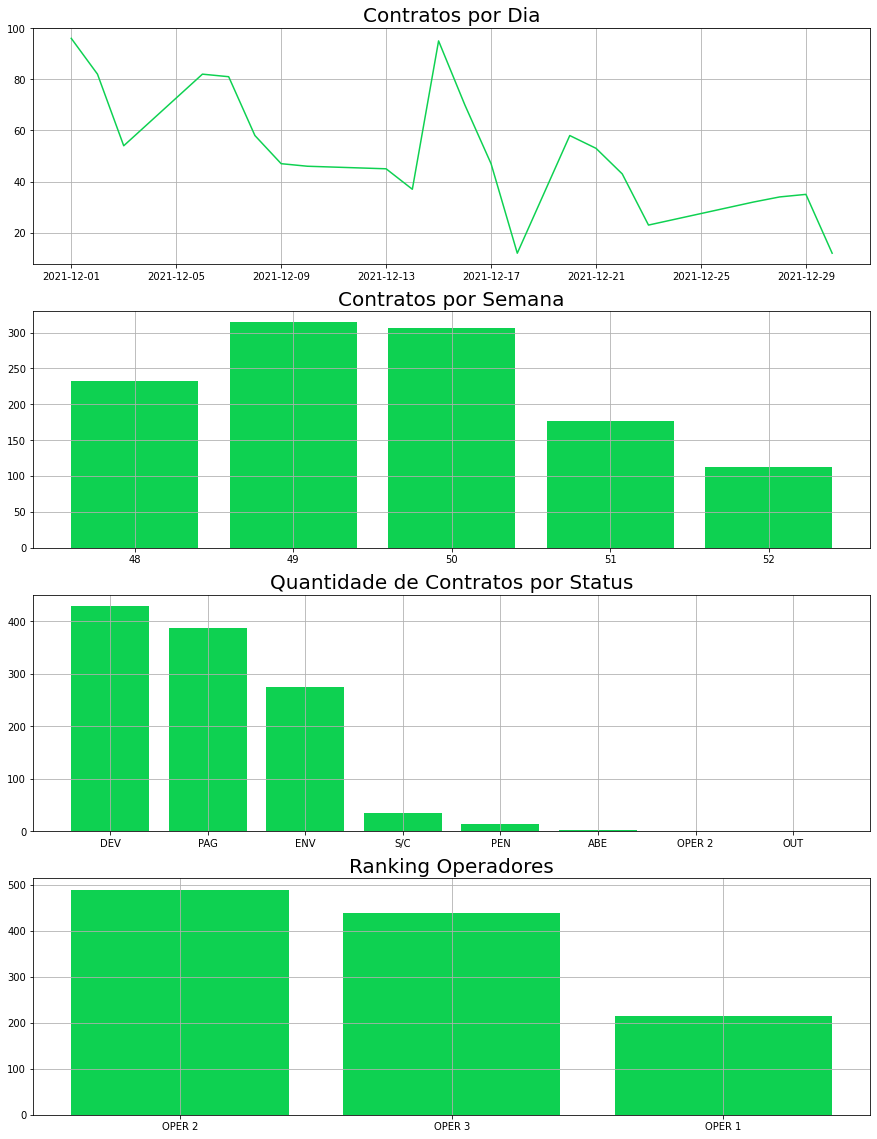

In [59]:
plt.figure(figsize=(15,20))

#grafico 1
graf1=df2[['data_contrato','cpf']].groupby('data_contrato').count().reset_index()
plt.subplot(4,1,1)
plt.plot(graf1['data_contrato'],graf1['cpf'],color='#0ed151');
plt.title('Contratos por Dia',size=20)
plt.grid()
#grafico 2
graf2=df2[['semana_ano','cpf']].groupby('semana_ano').count().reset_index()
plt.subplot(4,1,2)
plt.bar(graf2['semana_ano'],graf2['cpf'],color='#0ed151');
plt.title('Contratos por Semana',size=20)
plt.grid()
#grafico3
graf3=df2[['status','cpf']].groupby('status').count().reset_index().sort_values('cpf',ascending=False)
plt.subplot(4,1,3)
plt.bar(graf3['status'],graf3['cpf'],color='#0ed151');
plt.title('Quantidade de Contratos por Status', size=20)
plt.grid()
plt.legend
#grafico4
graf4=df2[['oper','cpf']].groupby('oper').count().sort_values('cpf',ascending=False).reset_index()
graf4
plt.subplot(4,1,4)
plt.bar(graf4['oper'],graf4['cpf'],color='#0ed151')
plt.title('Ranking Operadores',size=20)
plt.grid()

plt.savefig('./image/geral1.png',dpi=150)

### Grafico 1

#### Tratamento

In [60]:
# achando média de quantidade de contratos por dia
media_c=df2[['data_contrato','cpf']].groupby('data_contrato').count().reset_index()
media_c['media_contrato']=media_c['cpf'].apply(lambda x: int(round(x/len(operadores),0)))

# achando média de valor de por dia
media_v=df2[['data_contrato','valor_credi']].groupby('data_contrato').sum().reset_index()
media_v['media_valor']=media_v['valor_credi'].apply(lambda x: round(x/len(operadores),2))

# drop
media_c=media_c.drop(columns='cpf')
media_v=media_v.drop(columns='valor_credi')

# criar db para gráfico
num_contr=df2[['data_contrato','oper','cpf']].groupby(['data_contrato','oper']).count().reset_index()
valor_contr=df2[['data_contrato','oper','valor_credi']].groupby(['data_contrato','oper']).sum().reset_index()

# concatenar
num_contr=pd.merge(num_contr,media_c,on='data_contrato',how='left')
valor_contr=pd.merge(valor_contr,media_v,on='data_contrato',how='left')

#### Gerar Gráficos

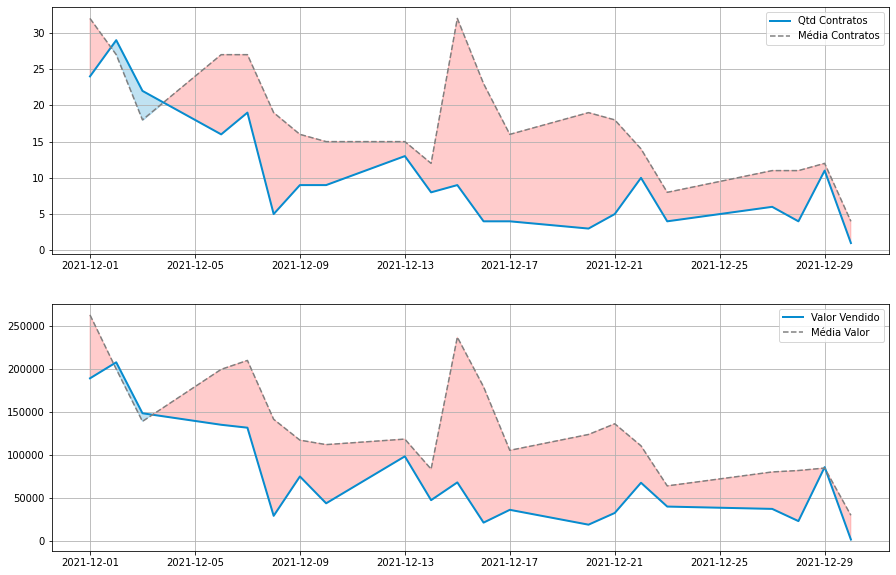

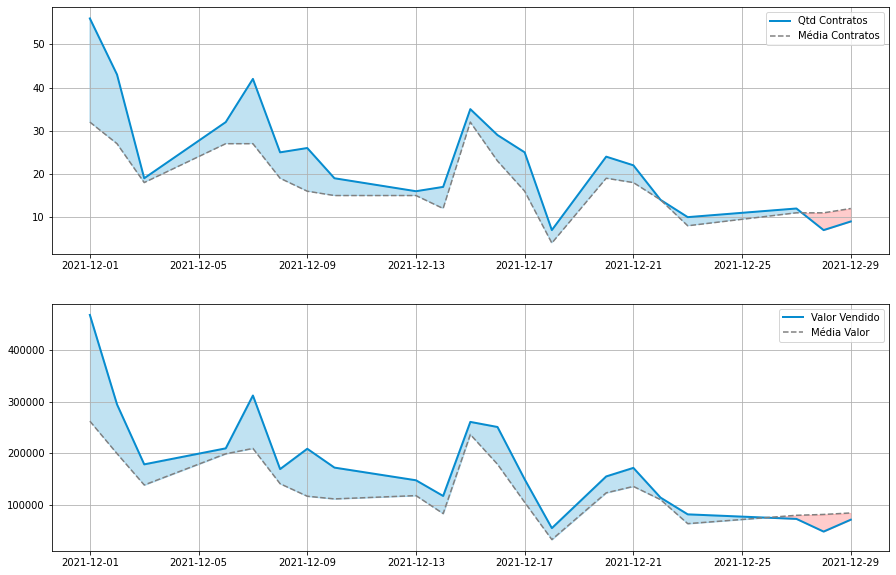

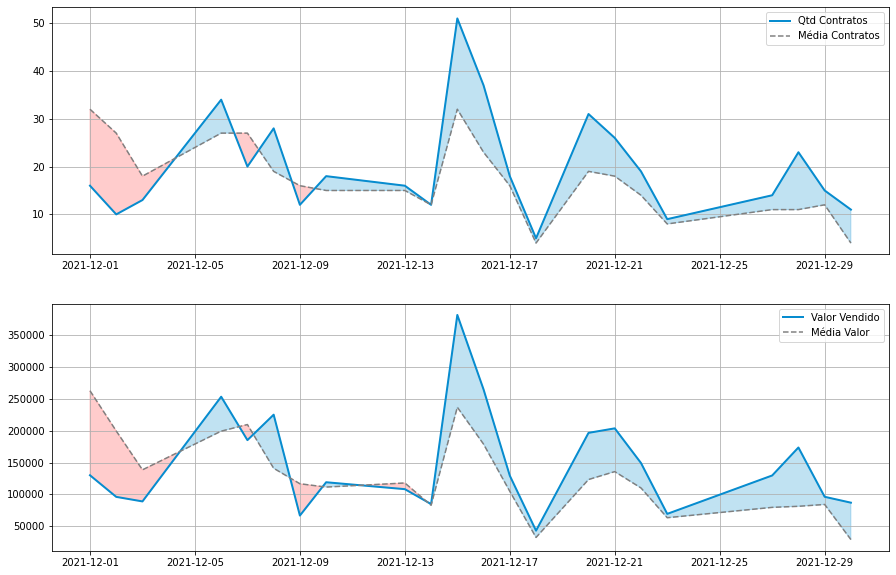

In [61]:
for nome in operadores:
  contr1=num_contr[num_contr['oper']==nome]
  valor1=valor_contr[valor_contr['oper']==nome]
  #grafico
  plt.figure(figsize=(15,10))
  plt.subplot(2,1,1)
  plt.plot(contr1['data_contrato'],contr1['cpf'],color='#078ccf',linewidth=2,label='Qtd Contratos')
  plt.plot(contr1['data_contrato'],contr1['media_contrato'],color='gray',linestyle='--',label='Média Contratos')
  plt.fill_between(contr1['data_contrato'],contr1['cpf'],contr1['media_contrato'],where=(contr1['cpf']>contr1['media_contrato']),
                  interpolate=True,color='#078ccf',alpha=0.25)
  plt.fill_between(contr1['data_contrato'],contr1['cpf'],contr1['media_contrato'],where=(contr1['cpf']<contr1['media_contrato']),
                  interpolate=True,
                  color='red',alpha=0.2)
  plt.grid()
  plt.legend()
  plt.subplot(2,1,2)
  plt.plot(valor1['data_contrato'],valor1['valor_credi'],color='#078ccf',linewidth='2',label='Valor Vendido')
  plt.plot(valor1['data_contrato'],valor1['media_valor'],color='gray',linestyle='--',label='Média Valor')
  plt.fill_between(valor1['data_contrato'],valor1['valor_credi'],valor1['media_valor'],color='#078ccf',
                  where=(valor1['valor_credi']>valor1['media_valor']),interpolate=True,alpha=0.25)
  plt.fill_between(valor1['data_contrato'],valor1['valor_credi'],valor1['media_valor'],color='red',
                  where=(valor1['valor_credi']<valor1['media_valor']),interpolate=True,alpha=0.2)
  plt.grid()
  plt.legend()
  plt.savefig('image\\' + nome + '1.png',dpi=150)

### Grafico 2


C:\Users\rafae\AppData\Local\Temp\ipykernel_28260\3048789573.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_graf=df_graf.append(t)
C:\Users\rafae\AppData\Local\Temp\ipykernel_28260\3048789573.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_graf=df_graf.append(t)
C:\Users\rafae\AppData\Local\Temp\ipykernel_28260\3048789573.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_graf=df_graf.append(t)
C:\Users\rafae\AppData\Local\Temp\ipykernel_28260\3048789573.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_graf=df_graf.append(t)
C:\Users\rafae\AppData\Local\Temp\ipykernel_28260\3048789573.py:11: FutureWarning: T

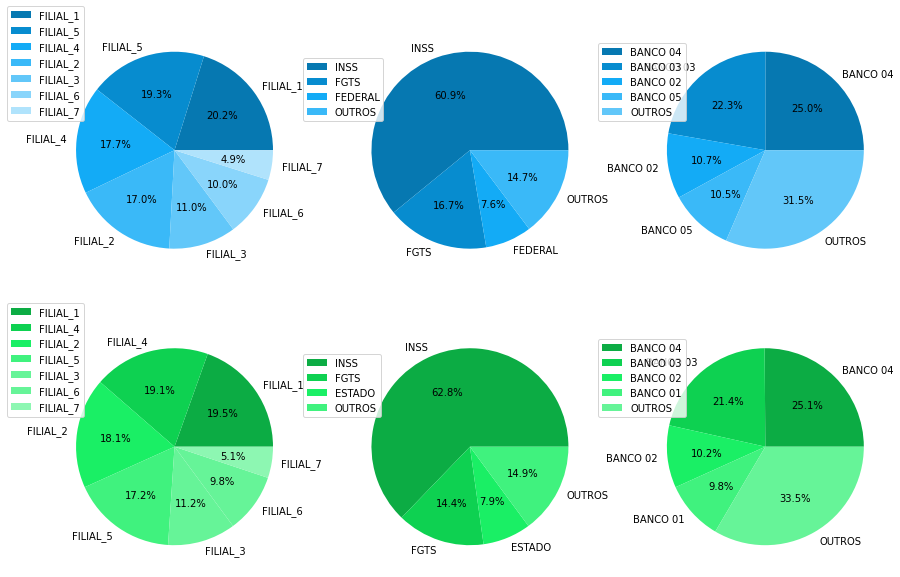

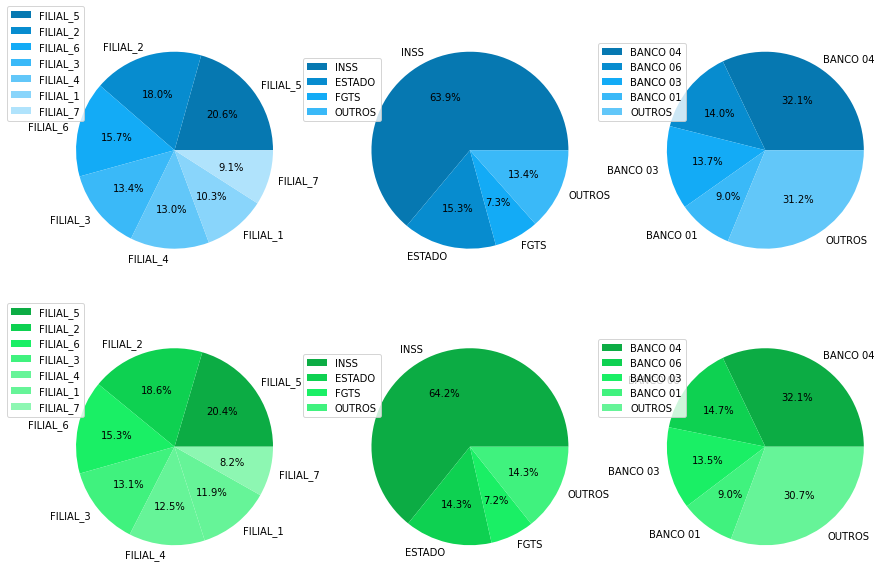

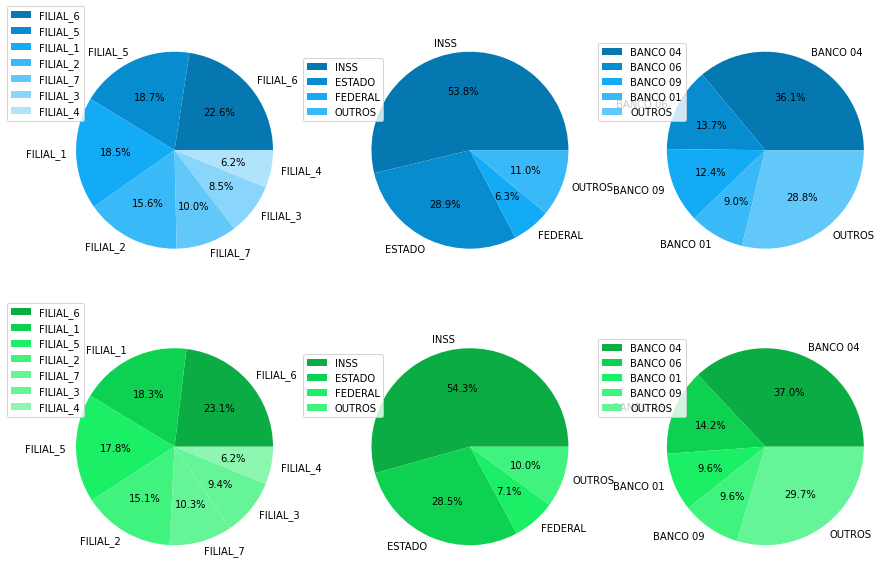

In [72]:
for nome in operadores:
    plt.figure(figsize=(15,10))
    graf=df2[df2['oper']==nome]

    #filial
    plt.subplot(2,3,1)
    filial1=graf[['valor_credi','filial']].groupby('filial').sum().reset_index().sort_values('valor_credi',ascending=False)
    plt.pie(filial1['valor_credi'],labels=filial1['filial'],autopct='%1.1f%%',colors=azuis[:len(filial1['filial'])])
    plt.legend(loc='lower left',bbox_to_anchor=(-0.2,0.6))

    plt.subplot(2,3,4)
    filial2=graf[['valor_credi','filial']].groupby('filial').count().reset_index().sort_values('valor_credi',ascending=False)
    plt.pie(filial2['valor_credi'],labels=filial2['filial'],autopct='%1.1f%%',colors=verdes[:len(filial2['filial'])])
    plt.legend(loc='lower left',bbox_to_anchor=(-0.2,0.6))

    #nome_produto
    plt.subplot(2,3,2)
    produto1=graf[['nome_produto','valor_credi']].groupby('nome_produto').sum().reset_index().sort_values('valor_credi',ascending=False)
    produto1=maiores(produto1,3)
    plt.pie(produto1['valor_credi'],labels=produto1['nome_produto'],autopct='%1.1f%%',colors=azuis[:len(produto1['nome_produto'])])
    plt.legend(loc='lower left',bbox_to_anchor=(-0.2,0.6))

    plt.subplot(2,3,5)
    produto2=graf[['nome_produto','valor_credi']].groupby('nome_produto').count().reset_index().sort_values('valor_credi',ascending=False)
    produto2=maiores(produto2,3)
    plt.pie(produto2['valor_credi'],labels=produto2['nome_produto'],autopct='%1.1f%%',colors=verdes[:len(produto2['nome_produto'])])
    plt.legend(loc='lower left',bbox_to_anchor=(-0.2,0.6))

    #nome_banco
    plt.subplot(2,3,3)
    banco1=graf[['nome_banco','valor_credi']].groupby('nome_banco').sum().reset_index().sort_values('valor_credi',ascending=False)
    banco1=maiores(banco1,4)
    plt.pie(banco1['valor_credi'],labels=banco1['nome_banco'],autopct='%1.1f%%',colors=azuis[:len(banco1['nome_banco'])])
    plt.legend(loc='lower left',bbox_to_anchor=(-0.2,0.6));

    plt.subplot(2,3,6)
    banco2=graf[['nome_banco','valor_credi']].groupby('nome_banco').count().reset_index().sort_values('valor_credi',ascending=False)
    banco2=maiores(banco2,4)
    plt.pie(banco2['valor_credi'],labels=banco2['nome_banco'],autopct='%1.1f%%',colors=verdes[:len(banco2['nome_banco'])])
    plt.legend(loc='lower left',bbox_to_anchor=(-0.2,0.6));
    plt.savefig('image\\' + nome + '2.png',dpi=150)


### Grafico 3

C:\Users\rafae\AppData\Local\Temp\ipykernel_28260\3048789573.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_graf=df_graf.append(t)
C:\Users\rafae\AppData\Local\Temp\ipykernel_28260\3048789573.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_graf=df_graf.append(t)
C:\Users\rafae\AppData\Local\Temp\ipykernel_28260\3048789573.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_graf=df_graf.append(t)


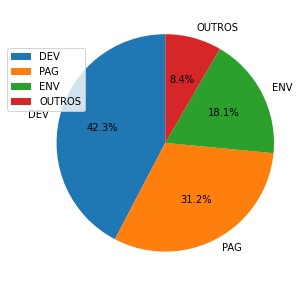

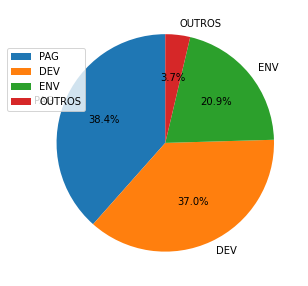

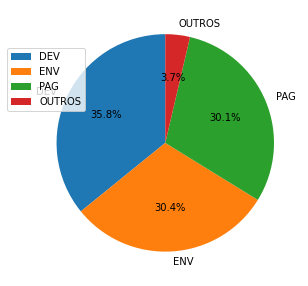

In [75]:
for nome in operadores:
    plt.figure(figsize=(5,5))
    graf=df2[df2['oper']==nome][['status','cpf']].groupby('status').count().reset_index().sort_values('cpf',ascending=False)
    graf=maiores(graf,3)
    plt.pie(graf['cpf'],labels=graf['status'],autopct='%1.1f%%',startangle=90)
    plt.legend(loc='lower left',bbox_to_anchor=(-0.1,0.6))

    plt.savefig('image\\' + nome + '3.png')


# 3. EXPORT

In [76]:
qtd=df2[['oper','valor_credi']].groupby('oper').count().reset_index()
vlr=df2[['oper','valor_credi']].groupby('oper').sum().reset_index()

In [83]:
class PDF(FPDF):
    def header(self):
        self.image('image\logo.png',5,5,18)
        self.set_font('arial','B',20)
        self.cell(0,10,'Relatório Operadores',ln=True,align='C')
        self.ln(10)
    def footer(self):
        self.set_y(-15)
        self.set_font('arial','I',10)
        self.cell(0,10,f'Pagina {self.page_no()}/{{nb}}',align='R')

pdf = PDF('P','mm','A4')
pdf.alias_nb_pages()
pdf.add_page()
pdf.image('image\\home_page.png',0,0,210)
pdf.set_auto_page_break(auto=True,margin=15)
pdf.set_font('arial','',12)
pdf.image('image\\geral1.png',5,40,w=200)
pdf.ln(210)
for nome in operadores:
    quantidade=qtd[qtd['oper']==nome]['valor_credi'].values[0]
    valor=str("R$: {:,.2f}".format(vlr[vlr['oper']==nome]['valor_credi'].values[0]))
    pdf.add_page()
    pdf.set_font('arial','',12)
    pdf.cell(0,10,nome,ln=True,align='C')
    pdf.ln(35)
    pdf.set_font('arial','',10)
    pdf.cell(50,10,f'Total Contratos: {quantidade}',ln=True)
    pdf.cell(50,10,f'Valor Total: {valor}',ln=True)
    pdf.ln(90)
    pdf.image('image\\' + nome + '.jpg',10,30,40)
    pdf.image('image\\' + nome + '1.png',45,35,170)
    pdf.image('image\\' + nome + '2.png',15,150,200)
    pdf.image('image\\' + nome + '3.png',0,87,70)
    pdf.set_font('arial','',7)
    pdf.cell(20,5,'Numero Contratos',ln=True)
    pdf.ln(50)
    pdf.cell(20,5,'Valor Contratos',ln=True)

pdf.output('Relatorio.pdf')
print('Finalizado')

Finalizado
